<a href="https://colab.research.google.com/github/pradjones/Calypso-Trading-bot/blob/master/MQG_DJI_linearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression Model for correlations between the DOW and MQG price


**Objectives:**
  * Initial exploratory data analysis
  * Use the `LinearRegressor` class in TensorFlow to predict median MQG prices
  * Evaluate the accuracy of a model's predictions using Root Mean Squared Error (RMSE)
  * Improve the accuracy of a model by tuning its hyperparameters

Data is sourced from [market index website](https://www.marketindex.com.au/asx/mqg)

## Setup
In this first cell, we'll load the necessary libraries.

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

Next, we'll load our data set.

In [0]:
mqg_dji_dataframe = pd.read_csv("https://raw.githubusercontent.com/pradjones/Calypso-Trading-bot/master/MQG.csv", sep=",", error_bad_lines=False)

We'll randomize the data, just to be sure not to get any pathological ordering effects that might harm the performance of Stochastic Gradient Descent. 

In [14]:
mqg_dji_dataframe = mqg_dji_dataframe.reindex(
    np.random.permutation(mqg_dji_dataframe.index))
mqg_dji_dataframe

,Date,MQG-Open,High,Low,MQG-Close,Volume,Date.1,DJI-Open,High.1,Low.1,DJI-Close,Volume.1
967,28/08/15,76.7,77.8,76.4,76.9,2679236,25/08/15,15882.3,16312.9,15651.2,15666.4,213220000
1287,26/05/14,59.7,60.3,59.6,60.3,840279,19/05/14,16490.3,16526.3,16442.1,16511.9,82180000
3034,28/06/07,84.9,85.1,84.2,84.5,2470364,11/06/07,13424.4,13478.1,13381.6,13425.0,183300000
2660,15/12/08,29.1,29.6,28.6,29.0,1497534,2/12/08,8153.8,8437.2,8143.5,8419.1,307520000
1935,28/10/11,25.1,25.3,24.3,24.7,5792432,18/10/11,11396.2,11652.7,11296.1,11577.0,201410000
...,...,...,...,...,...,...,...,...,...,...,...,...
821,30/03/16,64.6,65.1,64.2,64.6,1148435,24/03/16,17485.3,17517.1,17399.0,17515.7,84100000
1792,25/05/12,25.6,25.9,25.2,25.4,2607969,14/05/12,12818.5,12818.9,12661.5,12695.3,143190000
1334,17/03/14,53.9,54.7,53.9,54.4,632142,12/03/14,16350.7,16364.7,16260.0,16340.1,77900000
3276,12/07/06,66.8,67.5,66.6,67.0,566470,22/06/06,11077.8,11077.8,10986.1,11019.1,250460000


## Examine the Data


In [15]:
mqg_dji_dataframe.describe()

,MQG-Open,High,Low,MQG-Close,Volume,DJI-Open,High.1,Low.1,DJI-Close,Volume.1
count,4903.0,4903.0,4903.0,4903.0,4903.0,4903.0,4903.0,4903.0,4903.0,4903.0
mean,54.2,54.7,53.7,54.2,1344912.9,13696.9,13776.6,13614.1,13699.6,217859180.1
std,27.5,27.7,27.3,27.5,1136062.3,4809.3,4817.7,4800.1,4810.2,99910224.1
min,15.1,16.1,14.8,15.5,12202.0,6547.0,6709.6,6470.0,6547.0,8410000.0
25%,31.9,32.2,31.6,31.9,643117.5,10398.5,10455.1,10329.9,10398.7,142335000.0
50%,47.1,47.6,46.6,47.1,1032015.0,11951.4,12043.5,11860.1,11955.0,213670000.0
75%,73.5,74.1,72.5,73.4,1714826.0,16535.1,16616.6,16459.7,16539.2,272570000.0
max,135.9,136.8,135.1,136.2,23903480.0,26833.5,26951.8,26789.1,26828.4,900510000.0


## Build the First Model

In this exercise, we'll try to predict `MQG-Close`, which will be our label (sometimes also called a target). We'll use `DJI-Close` as our input feature.


To train our model, we'll use the [LinearRegressor](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearRegressor) interface provided by the TensorFlow [Estimator](https://www.tensorflow.org/get_started/estimator) API. This API takes care of a lot of the low-level model plumbing, and exposes convenient methods for performing model training, evaluation, and inference.

### Step 1: Define Features and Configure Feature Columns

In order to import our training data into TensorFlow, we need to specify what type of data each feature contains. There are two main types of data we'll use in this and future exercises:

* **Categorical Data**: Data that is textual. In this exercise, our housing data set does not contain any categorical features, but examples you might see would be the home style, the words in a real-estate ad.

* **Numerical Data**: Data that is a number (integer or float) and that you want to treat as a number. As we will discuss more later sometimes you might want to treat numerical data (e.g., a postal code) as if it were categorical.

In TensorFlow, we indicate a feature's data type using a construct called a **feature column**. Feature columns store only a description of the feature data; they do not contain the feature data itself.


In [0]:
# Define the input feature: total_rooms.
my_feature = mqg_dji_dataframe[["DJI-Close"]]

# Configure a numeric feature column for total_rooms.
feature_columns = [tf.feature_column.numeric_column("DJI-Close")]

**NOTE:** The shape of our `total_rooms` data is a one-dimensional array (a list of the total number of rooms for each block). This is the default shape for `numeric_column`, so we don't have to pass it as an argument.

### Step 2: Define the Target

Next, we'll define our target, which is `median_house_value`. Again, we can pull it from our `california_housing_dataframe`:

In [0]:
# Define the label.
targets = mqg_dji_dataframe["MQG-Close"]

### Step 3: Configure the LinearRegressor

Next, we'll configure a linear regression model using LinearRegressor. We'll train this model using the `GradientDescentOptimizer`, which implements Mini-Batch Stochastic Gradient Descent (SGD). The `learning_rate` argument controls the size of the gradient step.

**NOTE:** To be safe, we also apply [gradient clipping](https://developers.google.com/machine-learning/glossary/#gradient_clipping) to our optimizer via `clip_gradients_by_norm`. Gradient clipping ensures the magnitude of the gradients do not become too large during training, which can cause gradient descent to fail. 

In [0]:
# Use gradient descent as the optimizer for training the model.
my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# Configure the linear regression model with our feature columns and optimizer.
# Set a learning rate of 0.0000001 for Gradient Descent.
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)

### Step 4: Define the Input Function

To import our California housing data into our `LinearRegressor`, we need to define an input function, which instructs TensorFlow how to preprocess
the data, as well as how to batch, shuffle, and repeat it during model training.

First, we'll convert our *pandas* feature data into a dict of NumPy arrays. We can then use the TensorFlow [Dataset API](https://www.tensorflow.org/programmers_guide/datasets) to construct a dataset object from our data, and then break
our data into batches of `batch_size`, to be repeated for the specified number of epochs (num_epochs). 

**NOTE:** When the default value of `num_epochs=None` is passed to `repeat()`, the input data will be repeated indefinitely.

Next, if `shuffle` is set to `True`, we'll shuffle the data so that it's passed to the model randomly during training. The `buffer_size` argument specifies
the size of the dataset from which `shuffle` will randomly sample.

Finally, our input function constructs an iterator for the dataset and returns the next batch of data to the LinearRegressor.

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
  
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

**NOTE:** We'll continue to use this same input function in later exercises. For more
detailed documentation of input functions and the `Dataset` API, see the [TensorFlow Programmer's Guide](https://www.tensorflow.org/programmers_guide/datasets).

### Step 5: Train the Model

We can now call `train()` on our `linear_regressor` to train the model. We'll wrap `my_input_fn` in a `lambda`
so we can pass in `my_feature` and `targets` as arguments (see this [TensorFlow input function tutorial](https://www.tensorflow.org/get_started/input_fn#passing_input_fn_data_to_your_model) for more details), and to start, we'll
train for 100 steps.

In [0]:
_ = linear_regressor.train(
    input_fn = lambda:my_input_fn(my_feature, targets),
    steps=100
)

### Step 6: Evaluate the Model

Let's make predictions on that training data, to see how well our model fit it during training.

**NOTE:** Training error measures how well your model fits the training data, but it **_does not_** measure how well your model **_generalizes to new data_**. In later exercises, you'll explore how to split your data to evaluate your model's ability to generalize.


In [25]:
# Create an input function for predictions.
# Note: Since we're making just one prediction for each example, we don't 
# need to repeat or shuffle the data here.
prediction_input_fn =lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)

# Call predict() on the linear_regressor to make predictions.
predictions = linear_regressor.predict(input_fn=prediction_input_fn)

# Format predictions as a NumPy array, so we can calculate error metrics.
predictions = np.array([item['predictions'][0] for item in predictions])

# Print Mean Squared Error and Root Mean Squared Error.
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

Mean Squared Error (on training data): 3613.550
Root Mean Squared Error (on training data): 60.113


Is this a good model? How would you judge how large this error is?

Mean Squared Error (MSE) can be hard to interpret, so we often look at Root Mean Squared Error (RMSE)
instead.  A nice property of RMSE is that it can be interpreted on the same scale as the original targets.

Let's compare the RMSE to the difference of the min and max of our targets:

In [29]:
min_value = mqg_dji_dataframe["MQG-Close"].min()
max_value = mqg_dji_dataframe["MQG-Close"].max()
min_max_difference = max_value - min_value

print("Min. MQG Value: %0.3f" % min_value)
print("Max. MQG Value: %0.3f" % max_value)
print("Difference between Min. and Max.: %0.3f" % min_max_difference)
print("Root Mean Squared Error: %0.3f" % root_mean_squared_error)

Min. MQG Value: 15.489
Max. MQG Value: 136.200
Difference between Min. and Max.: 120.711
Root Mean Squared Error: 60.113


Our error spans nearly half the range of the target values. Can we do better?

This is the question that nags at every model developer. Let's develop some basic strategies to reduce model error.

The first thing we can do is take a look at how well our predictions match our targets, in terms of overall summary statistics.

In [30]:
calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)
calibration_data.describe()

,predictions,targets
count,4903.0,4903.0
mean,0.7,54.2
std,0.2,27.5
min,0.3,15.5
25%,0.5,31.9
50%,0.6,47.1
75%,0.8,73.4
max,1.3,136.2


Okay, maybe this information is helpful. How does the mean value compare to the model's RMSE? How about the various quantiles?

We can also visualize the data and the line we've learned.  Recall that linear regression on a single feature can be drawn as a line mapping input *x* to output *y*.

First, we'll get a uniform random sample of the data so we can make a readable scatter plot.

In [0]:
sample = mqg_dji_dataframe.sample(n=300)

Next, we'll plot the line we've learned, drawing from the model's bias term and feature weight, together with the scatter plot. The line will show up red.

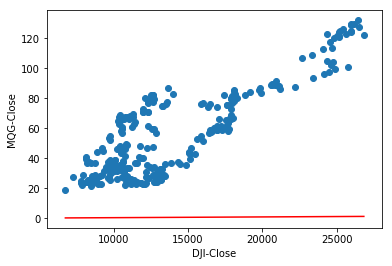

In [32]:
# Get the min and max total_rooms values.
x_0 = sample["DJI-Close"].min()
x_1 = sample["DJI-Close"].max()

# Retrieve the final weight and bias generated during training.
weight = linear_regressor.get_variable_value('linear/linear_model/DJI-Close/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

# Get the predicted median_house_values for the min and max total_rooms values.
y_0 = weight * x_0 + bias 
y_1 = weight * x_1 + bias

# Plot our regression line from (x_0, y_0) to (x_1, y_1).
plt.plot([x_0, x_1], [y_0, y_1], c='r')

# Label the graph axes.
plt.ylabel("MQG-Close")
plt.xlabel("DJI-Close")

# Plot a scatter plot from our data sample.
plt.scatter(sample["DJI-Close"], sample["MQG-Close"])

# Display graph.
plt.show()

This initial line looks way off.  See if you can look back at the summary stats and see the same information encoded there.

Together, these initial sanity checks suggest we may be able to find a much better line.

## Tweak the Model Hyperparameters
For this exercise, we've put all the above code in a single function for convenience. You can call the function with different parameters to see the effect.

In this function, we'll proceed in 10 evenly divided periods so that we can observe the model improvement at each period.

For each period, we'll compute and graph training loss.  This may help you judge when a model is converged, or if it needs more iterations.

We'll also plot the feature weight and bias term values learned by the model over time.  This is another way to see how things converge.

In [0]:
def train_model(learning_rate, steps, batch_size, input_feature="DJI-Close"):
  """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = mqg_dji_dataframe[[my_feature]]
  my_label = "MQG-Close"
  targets = mqg_dji_dataframe[my_label]

  # Create feature columns.
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
  
  # Create input functions.
  training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
  prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = mqg_dji_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Output a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

## Task 1:  Minimising the RMSE

Tweak the model hyperparameters to improve loss and better match the target distribution.

Training model...
RMSE (on training data):
  period 00 : 14.87
  period 01 : 14.87
  period 02 : 14.87
  period 03 : 14.98
  period 04 : 14.87
  period 05 : 14.98
  period 06 : 14.87
  period 07 : 14.87
  period 08 : 14.87
  period 09 : 14.87
Model training finished.


,predictions,targets
count,4903.0,4903.0
mean,54.8,54.2
std,19.2,27.5
min,26.2,15.5
25%,41.6,31.9
50%,47.8,47.1
75%,66.2,73.4
max,107.3,136.2


Final RMSE (on training data): 14.87


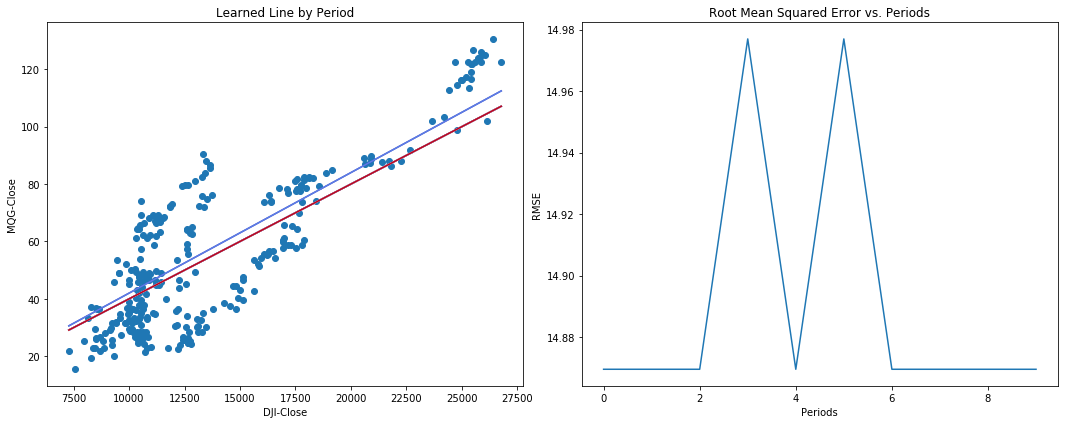

In [41]:
train_model(
    learning_rate=0.00002,
    steps=500,
    batch_size=100
)

### Best Parameters
These are the best parameters I found whilst trying to minimise the error.Let me know if you guys find a better RMSE value
Current Best: 14.87

Training model...
RMSE (on training data):
  period 00 : 17.68
  period 01 : 14.98
  period 02 : 15.32
  period 03 : 14.87
  period 04 : 14.98
  period 05 : 14.87
  period 06 : 14.98
  period 07 : 14.87
  period 08 : 14.98
  period 09 : 15.63
Model training finished.


,predictions,targets
count,4903.0,4903.0
mean,60.3,54.2
std,21.2,27.5
min,28.8,15.5
25%,45.8,31.9
50%,52.6,47.1
75%,72.8,73.4
max,118.1,136.2


Final RMSE (on training data): 15.63


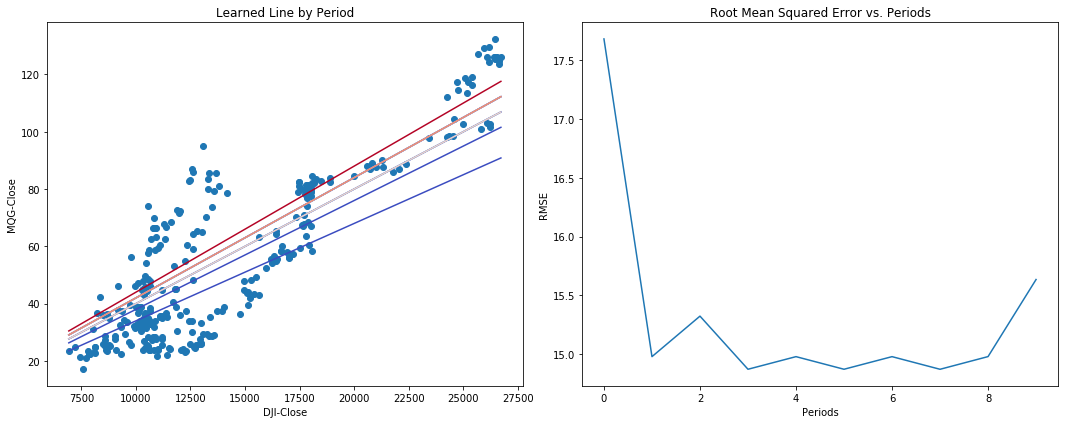

In [36]:
train_model(
    learning_rate=0.00002,
    steps=500,
    batch_size=100
)

## Evaluate Model (Split data)